In [7]:
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score, confusion_matrix, classification_report, accuracy_score, log_loss


In [10]:


class Dense:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.biases = np.zeros((1, output_dim))
        self.weights_grad = None
        self.biases_grad = None

    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, grad_output):
        self.weights_grad = np.dot(self.input.T, grad_output)
        self.biases_grad = np.sum(grad_output, axis=0, keepdims=True)
        return np.dot(grad_output, self.weights.T)

class ReLU:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        return grad_output * (self.input > 0)



class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate

    def forward(self, x, training=True):
        if training:
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=x.shape) / (1 - self.dropout_rate)   
            # self.mask = (np.random.rand(*x.shape) > self.dropout_rate) / (1.0 - self.dropout_rate)
            return x * self.mask
        return x

    def backward(self, grad_output):
        return grad_output * self.mask

class Softmax:
    def forward(self, x):
        exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.output = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)
        return self.output
    
    

    def backward(self, y_true):
        grad_input = self.output - y_true
        return grad_input / y_true.shape[0]
    
        # return self.output - y_true  # Assuming combined with cross-entropy loss



In [11]:
class BatchNormalization:
    def __init__(self, dim, momentum=0.9, epsilon=1e-8):
        self.gamma = np.ones(dim)
        self.beta = np.zeros(dim)
        self.momentum = momentum
        self.epsilon = epsilon
        self.running_mean = np.zeros(dim)
        self.running_var = np.zeros(dim)

    def forward(self, x, training=True):
        self.input = x
        if training:
            # Compute mean and variance of the current batch
            self.batch_mean = np.mean(x, axis=0)
            self.batch_var = np.var(x, axis=0)
            # Update running mean and variance
            self.running_mean = self.momentum * self.batch_mean + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * self.batch_var + (1 - self.momentum) * self.running_var
            # Normalize using batch statistics
            self.normalized = (x - self.batch_mean) / np.sqrt(self.batch_var + self.epsilon)
        else:
            # Normalize using running mean and variance during testing
            self.normalized = (x - self.running_mean) / np.sqrt(self.running_var + self.epsilon)

        # Scale and shift
        out = self.gamma * self.normalized + self.beta
        return out

    def backward(self, grad_output):
        # Gradients for gamma and beta
        self.gamma_grad = np.sum(grad_output * self.normalized, axis=0)
        self.beta_grad = np.sum(grad_output, axis=0)

        # Backpropagation through normalization
        grad_norm = grad_output * self.gamma
        batch_var_eps = self.batch_var + self.epsilon
        grad_var = np.sum(grad_norm * (self.input - self.batch_mean) * -0.5 * np.power(batch_var_eps, -1.5), axis=0)
        grad_mean = np.sum(grad_norm * -1 / np.sqrt(batch_var_eps), axis=0) + grad_var * np.mean(-2 * (self.input - self.batch_mean), axis=0)

        grad_input = grad_norm / np.sqrt(batch_var_eps) + grad_var * 2 * (self.input - self.batch_mean) / self.input.shape[0] + grad_mean / self.input.shape[0]
        return grad_input


In [12]:
class Adam:
    def __init__(self, layers, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # Store the layers directly
        self.layers = layers
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

        # Initialize m and v for all parameters in the layers
        for layer in self.layers:
            if isinstance(layer, Dense):
                self.m[id(layer.weights)] = np.zeros_like(layer.weights)
                self.v[id(layer.weights)] = np.zeros_like(layer.weights)
                self.m[id(layer.biases)] = np.zeros_like(layer.biases)
                self.v[id(layer.biases)] = np.zeros_like(layer.biases)
            if isinstance(layer, BatchNormalization):
                self.m[id(layer.gamma)] = np.zeros_like(layer.gamma)
                self.v[id(layer.gamma)] = np.zeros_like(layer.gamma)
                self.m[id(layer.beta)] = np.zeros_like(layer.beta)
                self.v[id(layer.beta)] = np.zeros_like(layer.beta)

    def step(self):
        self.t += 1
        for layer in self.layers:
            if isinstance(layer, Dense):
                # Update weights
                grad = layer.weights_grad
                m = self.m[id(layer.weights)]
                v = self.v[id(layer.weights)]
                m = self.beta1 * m + (1 - self.beta1) * grad
                v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)
                m_hat = m / (1 - self.beta1 ** self.t)
                v_hat = v / (1 - self.beta2 ** self.t)
                layer.weights -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.m[id(layer.weights)], self.v[id(layer.weights)] = m, v

                # Update biases
                grad = layer.biases_grad
                m = self.m[id(layer.biases)]
                v = self.v[id(layer.biases)]
                m = self.beta1 * m + (1 - self.beta1) * grad
                v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)
                m_hat = m / (1 - self.beta1 ** self.t)
                v_hat = v / (1 - self.beta2 ** self.t)
                layer.biases -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.m[id(layer.biases)], self.v[id(layer.biases)] = m, v

            if isinstance(layer, BatchNormalization):
                # Update gamma
                grad = layer.gamma_grad
                m = self.m[id(layer.gamma)]
                v = self.v[id(layer.gamma)]
                m = self.beta1 * m + (1 - self.beta1) * grad
                v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)
                m_hat = m / (1 - self.beta1 ** self.t)
                v_hat = v / (1 - self.beta2 ** self.t)
                layer.gamma -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.m[id(layer.gamma)], self.v[id(layer.gamma)] = m, v

                # Update beta
                grad = layer.beta_grad
                m = self.m[id(layer.beta)]
                v = self.v[id(layer.beta)]
                m = self.beta1 * m + (1 - self.beta1) * grad
                v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)
                m_hat = m / (1 - self.beta1 ** self.t)
                v_hat = v / (1 - self.beta2 ** self.t)
                layer.beta -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.m[id(layer.beta)], self.v[id(layer.beta)] = m, v


In [37]:
class TestNeuralNetwork1:
    def __init__(self, input_dim, output_dim, hidden_dim = 128, dropout_rate=0.5, lr=0.01):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.dense1 = Dense(input_dim, hidden_dim)
        self.batch_norm1 = BatchNormalization(hidden_dim)
        self.relu = ReLU()
        self.dropout = Dropout(dropout_rate)
        self.dense2 = Dense(hidden_dim, output_dim)
        self.softmax = Softmax()

        # Pass layers to Adam optimizer
        self.optimizer = Adam([self.dense1, self.batch_norm1, self.dense2], lr=lr)

    def forward(self, x, training=True):
        out = self.dense1.forward(x)
        out = self.batch_norm1.forward(out, training=training)
        out = self.relu.forward(out)
        out = self.dropout.forward(out, training=training)
        out = self.dense2.forward(out)
        return self.softmax.forward(out)

    def backward(self, y_true):
        # y_one_hot = np.eye(self.dense2.weights.shape[1])[y_true]
        grad_output = self.softmax.backward(y_true)
        grad_output = self.dense2.backward(grad_output)
        grad_output = self.dropout.backward(grad_output)
        grad_output = self.relu.backward(grad_output)
        grad_output = self.batch_norm1.backward(grad_output)
        # grad_output = self.dense1.backward(grad_output)
        self.dense1.backward(grad_output)

    def update_parameters(self):
        self.optimizer.step()
     

In [56]:
class TestNeuralNetwork2:
    def __init__(self, input_dim, output_dim, hidden_dim = 64, dropout_rate=0.5, lr=0.01):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.dense1 = Dense(input_dim, hidden_dim)
        self.batch_norm1 = BatchNormalization(hidden_dim)
        self.relu = ReLU()
        self.dropout = Dropout(dropout_rate)
        self.dense2 = Dense(hidden_dim, output_dim)
        self.softmax = Softmax()

        # Pass layers to Adam optimizer
        self.optimizer = Adam([self.dense1, self.batch_norm1, self.dense2], lr=lr)

    def forward(self, x, training=True):
        out = self.dense1.forward(x)
        out = self.batch_norm1.forward(out, training=training)
        out = self.relu.forward(out)
        out = self.dropout.forward(out, training=training)
        out = self.dense2.forward(out)
        return self.softmax.forward(out)

    def backward(self, y_true):
        # y_one_hot = np.eye(self.dense2.weights.shape[1])[y_true]
        grad_output = self.softmax.backward(y_true)
        grad_output = self.dense2.backward(grad_output)
        grad_output = self.dropout.backward(grad_output)
        grad_output = self.relu.backward(grad_output)
        grad_output = self.batch_norm1.backward(grad_output)
        # grad_output = self.dense1.backward(grad_output)
        self.dense1.backward(grad_output)

    def update_parameters(self):
        self.optimizer.step()

In [62]:
class TestNeuralNetwork3:
    def __init__(self, input_dim, output_dim, hidden_dim = 128, dropout_rate=0.5, lr=0.01):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.dense1 = Dense(input_dim, hidden_dim)
        self.batch_norm1 = BatchNormalization(hidden_dim)
        self.relu1 = ReLU()
        self.dropout1 = Dropout(dropout_rate)
        self.dense2 = Dense(hidden_dim, 64)
        self.batch_norm2 = BatchNormalization(64)
        self.relu2 = ReLU()
        self.dropout2 = Dropout(dropout_rate)
        self.dense3 = Dense(64, output_dim)
        self.softmax = Softmax()

        # Pass layers to Adam optimizer
        self.optimizer = Adam([self.dense1, self.batch_norm1, self.dense2, self.batch_norm2, self.dense3], lr=lr)

    def forward(self, x, training=True):
        out = self.dense1.forward(x)
        out = self.batch_norm1.forward(out, training=training)
        out = self.relu1.forward(out)
        out = self.dropout1.forward(out, training=training)
        out = self.dense2.forward(out)
        out = self.batch_norm2.forward(out, training=training)
        out = self.relu2.forward(out)
        out = self.dropout2.forward(out, training=training)
        out = self.dense3.forward(out)
        return self.softmax.forward(out)

    def backward(self, y_true):
        # y_one_hot = np.eye(self.dense2.weights.shape[1])[y_true]
        grad_output = self.softmax.backward(y_true)
        grad_output = self.dense3.backward(grad_output)
        grad_output = self.dropout2.backward(grad_output)
        grad_output = self.relu2.backward(grad_output)
        grad_output = self.batch_norm2.backward(grad_output)
        grad_output = self.dense2.backward(grad_output)
        grad_output = self.dropout1.backward(grad_output)
        grad_output = self.relu1.backward(grad_output)
        grad_output = self.batch_norm1.backward(grad_output)
        # grad_output = self.dense1.backward(grad_output)
        self.dense1.backward(grad_output)

    def update_parameters(self):
        self.optimizer.step()

In [14]:
from torchvision import datasets, transforms
transforms = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms, download=True)


/home/nabil/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from torch.utils.data import DataLoader, random_split

In [27]:
def hyperTune(model, train_dataset, output_dim):
    # Evaluate function
    def evaluate(model, data_loader):
        all_preds = []
        all_labels = []
        for images, labels in data_loader:
            images = images.view(images.size(0), -1).numpy()
            probs = model.forward(images, training=False)
            preds = np.argmax(probs, axis=1)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
        return all_labels, all_preds
    
    # Training function
    def train(model, train_loader, val_loader, num_epochs):
        training_losses = {}
        training_accuracy = {}
        val_losses = {} 
        val_accuracy = {}
        # all_val_preds = []
        # all_val_labels = []
        for epoch in range(num_epochs):
            training_loss = 0.0
            training_correct_preds = 0
            training_total_samples = 0
            val_loss = 0.0
            val_correct_preds = 0
            val_total_samples = 0
            val_macro_f1 = 0.0
            for images, labels in train_loader:
                images = images.view(images.size(0), -1).numpy()
                labels = np.eye(output_dim)[labels.numpy()]

            # Forward pass
                probs = model.forward(images, training=True)
                training_loss += -np.mean(np.sum(labels * np.log(probs + 1e-8), axis=1))
                
                # probs = probs.argmax(dim=1)
                
                # correct_preds += (probs == labels).sum().item()
                # total_samples += labels.size(0)
                batch_preds = np.argmax(probs, axis=1)
                batch_labels = labels.argmax(axis=1)  # Convert one-hot labels to class indices
                
                # Update correct predictions and total samples
                training_correct_preds += np.sum(batch_preds == batch_labels)
                training_total_samples += len(batch_labels)

                # Calculate accuracy for the epoch
                

            # Backward pass
                # dout = probs - labels
                model.backward(labels)
                model.update_parameters()
               
            training_loss /= len(train_loader)
            training_epoch_accuracy = training_correct_preds / training_total_samples 
            training_accuracy[epoch] = training_epoch_accuracy
            training_losses[epoch] = training_loss
            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss} , Training Accuracy: {training_epoch_accuracy}")
            
            for images , labels in val_loader:
                images = images.view(images.size(0), -1).numpy()
                labels = np.eye(output_dim)[labels.numpy()]
                
                probs = model.forward(images, training=False)
                
                val_loss += -np.mean(np.sum(labels * np.log(probs + 1e-8), axis=1))
                
                batch_preds = np.argmax(probs, axis=1)
                batch_labels = labels.argmax(axis=1)
                
                val_macro_f1 += f1_score(batch_labels, batch_preds, average='macro')
                
                val_correct_preds += np.sum(batch_preds == batch_labels)
                val_total_samples += len(batch_labels)
                
            val_loss /= len(val_loader)
            val_epoch_accuracy = val_correct_preds / val_total_samples
            val_accuracy[epoch] = val_epoch_accuracy
            val_losses[epoch] = val_loss
            val_macro_f1 /= len(val_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss} , Validation Accuracy: {val_epoch_accuracy} , Validation Macro F1: {val_macro_f1}")
            
         
        epochs = range(1 , num_epochs + 1)
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, list(training_losses.values()), label='Training Loss')
        plt.plot(epochs, list(val_losses.values()), label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid()
        plt.show() 
        
        
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, list(training_accuracy.values()), label='Training Accuracy')
        plt.plot(epochs, list(val_accuracy.values()), label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.grid()
        plt.show()
            
        val_labels, val_preds = evaluate(model, val_loader)
        val_conf_matrix = confusion_matrix(val_labels, val_preds)
        val_macro_f1_final = f1_score(val_labels, val_preds, average='macro')
        
        print("Validation Confusion Matrix:\n", val_conf_matrix)
        # print("Validation F1 Score:", val_f1)
        # print("Validation Accuracy:", val_accuracy)
        print("Validation Macro F1 Score:", val_macro_f1_final)
        
        
    
    
    
    batch_size = 64

# Split the training dataset into training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
    num_epochs = 20
    train(model, train_loader, val_loader, num_epochs)

            
   

#Different Models

Epoch 1/20, Training Loss: 0.5859940093088511 , Training Accuracy: 0.7898333333333334
Epoch 1/20, Validation Loss: 0.4110968562285375 , Validation Accuracy: 0.8536666666666667 , Validation Macro F1: 0.8409893747773297
Epoch 2/20, Training Loss: 0.47026209042346195 , Training Accuracy: 0.830375
Epoch 2/20, Validation Loss: 0.38170218434920566 , Validation Accuracy: 0.8576666666666667 , Validation Macro F1: 0.8450611734203389
Epoch 3/20, Training Loss: 0.439835883004077 , Training Accuracy: 0.840625
Epoch 3/20, Validation Loss: 0.3728021045070568 , Validation Accuracy: 0.8630833333333333 , Validation Macro F1: 0.8507414270815696
Epoch 4/20, Training Loss: 0.4208148919803512 , Training Accuracy: 0.8491458333333334
Epoch 4/20, Validation Loss: 0.3802314389718829 , Validation Accuracy: 0.8643333333333333 , Validation Macro F1: 0.8500603731521789
Epoch 5/20, Training Loss: 0.4079914878310355 , Training Accuracy: 0.8526041666666667
Epoch 5/20, Validation Loss: 0.3644346563822696 , Validation 

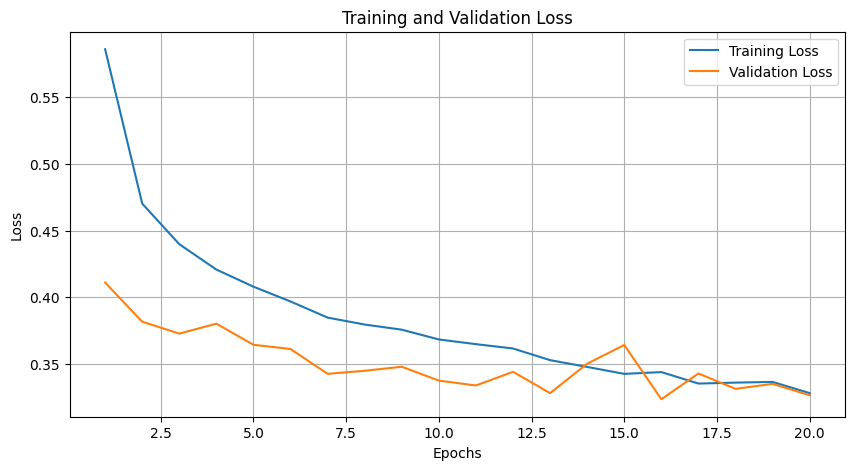

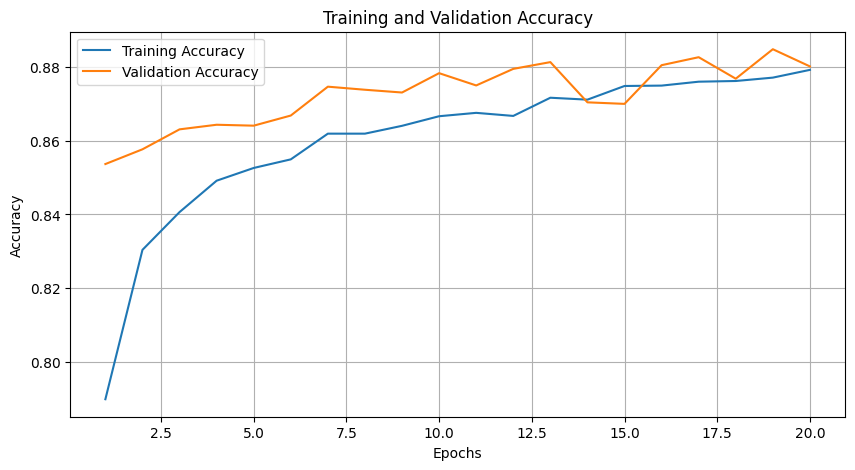

Validation Confusion Matrix:
 [[1001    2   10   51    6    1  128    0    9    1]
 [   1 1147    1   27    0    0    1    0    0    0]
 [  15    0  831   14  186    0  166    0    2    0]
 [  24    7    4 1120   35    0   24    0    2    0]
 [   1    1   40   37 1010    0   87    0    2    0]
 [   2    0    0    0    0 1169    0   26    2   11]
 [ 162    1   35   31   97    0  832    0   17    0]
 [   0    0    0    0    0   33    0 1149    2   42]
 [   1    0    3    8    6    6    9    3 1139    0]
 [   0    0    0    3    0   12    1   40    0 1164]]
Validation Macro F1 Score: 0.8797168427050612


In [28]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model1 = TestNeuralNetwork1(input_dim, output_dim)
hyperTune(model1, train_dataset, output_dim)

Epoch 1/20, Training Loss: 0.6358887660293209 , Training Accuracy: 0.7724791666666667
Epoch 1/20, Validation Loss: 0.42859923577430525 , Validation Accuracy: 0.84025 , Validation Macro F1: 0.8222873545426516
Epoch 2/20, Training Loss: 0.518708833326909 , Training Accuracy: 0.8137291666666666
Epoch 2/20, Validation Loss: 0.40033886586248507 , Validation Accuracy: 0.8526666666666667 , Validation Macro F1: 0.8387389723557451
Epoch 3/20, Training Loss: 0.48778234194646597 , Training Accuracy: 0.823125
Epoch 3/20, Validation Loss: 0.4058977998829545 , Validation Accuracy: 0.8491666666666666 , Validation Macro F1: 0.833416880865137
Epoch 4/20, Training Loss: 0.47351436269010866 , Training Accuracy: 0.8294166666666667
Epoch 4/20, Validation Loss: 0.3616578632936519 , Validation Accuracy: 0.867 , Validation Macro F1: 0.8521216444091272
Epoch 5/20, Training Loss: 0.4613010863213801 , Training Accuracy: 0.832625
Epoch 5/20, Validation Loss: 0.3791104239960039 , Validation Accuracy: 0.858 , Valid

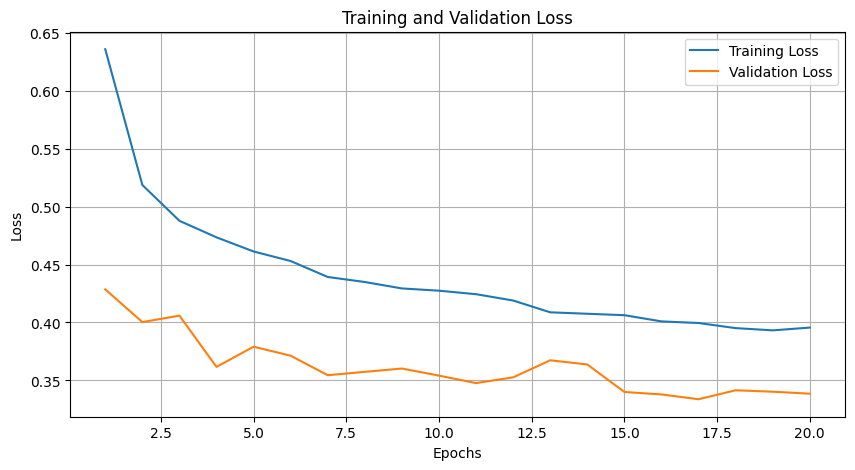

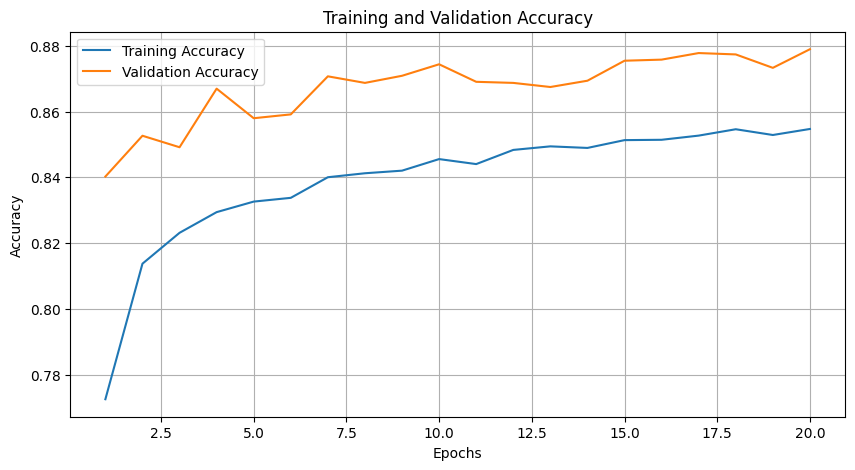

Validation Confusion Matrix:
 [[1001    3   14   56    3    0   70    0    8    0]
 [   2 1180    4   22    2    0    0    0    0    0]
 [  24    1  905    8  161    0   61    0    1    0]
 [  23    7    7 1083   52    0   21    0    1    0]
 [   2    2   57   40 1052    0   52    0    1    0]
 [   1    1    0    0    0 1172    0   32    4   20]
 [ 190    4  109   34  148    0  674    0    9    0]
 [   0    0    0    0    0   25    0 1136    2   58]
 [   7    0   10    5   13    6   17    3 1169    3]
 [   0    0    0    0    0   13    0   33    0 1176]]
Validation Macro F1 Score: 0.8756091091347965


In [32]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model2 = TestNeuralNetwork2(input_dim, output_dim)
hyperTune(model2, train_dataset, output_dim)

Epoch 1/20, Training Loss: 0.7058775196432214 , Training Accuracy: 0.7504166666666666
Epoch 1/20, Validation Loss: 0.47245654224432027 , Validation Accuracy: 0.8205833333333333 , Validation Macro F1: 0.8039174991549144
Epoch 2/20, Training Loss: 0.5627508539894852 , Training Accuracy: 0.8033541666666667
Epoch 2/20, Validation Loss: 0.4541976639491445 , Validation Accuracy: 0.8354166666666667 , Validation Macro F1: 0.8148278799972614
Epoch 3/20, Training Loss: 0.5238574085321395 , Training Accuracy: 0.8182916666666666
Epoch 3/20, Validation Loss: 0.390532019368447 , Validation Accuracy: 0.85525 , Validation Macro F1: 0.8423393527892465
Epoch 4/20, Training Loss: 0.5056263063942346 , Training Accuracy: 0.822125
Epoch 4/20, Validation Loss: 0.38777136905499315 , Validation Accuracy: 0.8521666666666666 , Validation Macro F1: 0.8421250124549012
Epoch 5/20, Training Loss: 0.48907328797238725 , Training Accuracy: 0.8284583333333333
Epoch 5/20, Validation Loss: 0.36873426816028815 , Validation

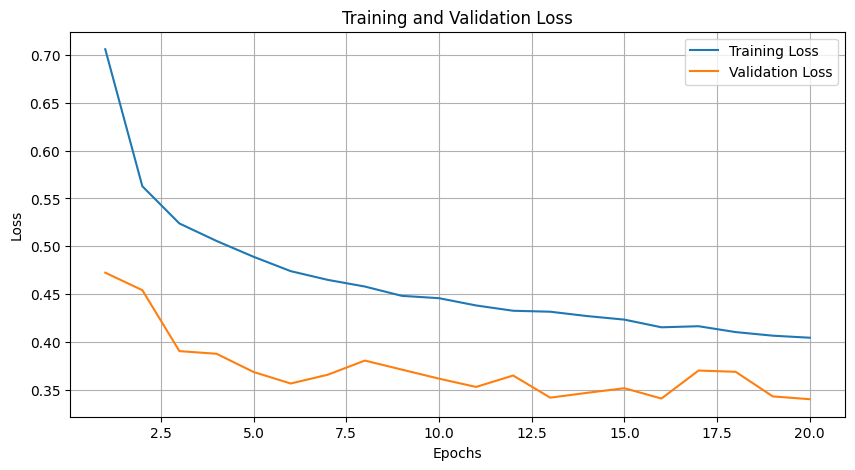

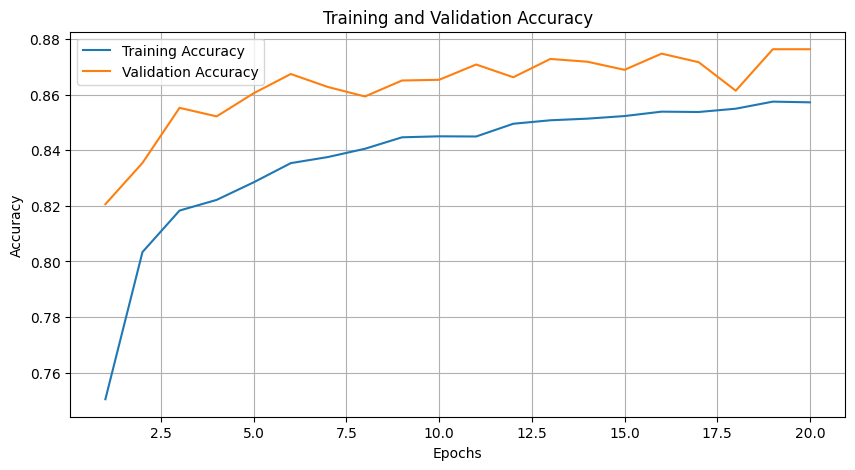

Validation Confusion Matrix:
 [[1107    6   10   26    4    0   35    0    5    0]
 [   4 1196    2   18    1    0    0    0    0    0]
 [  29    3 1002   13  127    0   46    0    0    0]
 [  55   18   10 1053   50    0   19    0    0    0]
 [   8    6   96   26  990    0   46    0    3    0]
 [   0    0    0    0    0 1128    1   29    2    7]
 [ 296    3  172   22  112    0  621    0    6    0]
 [   0    0    0    0    0   26    0 1150    2   24]
 [  12    1    6    6    4    2   13    4 1123    1]
 [   0    0    0    0    0   15    0   50    2 1146]]
Validation Macro F1 Score: 0.8737536717666682


In [33]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model3 = TestNeuralNetwork3(input_dim, output_dim)
hyperTune(model3, train_dataset, output_dim)

Epoch 1/20, Training Loss: 0.6304685743138569 , Training Accuracy: 0.7977708333333333
Epoch 1/20, Validation Loss: 0.44582955752695286 , Validation Accuracy: 0.8313333333333334 , Validation Macro F1: 0.8193589304967361
Epoch 2/20, Training Loss: 0.46237107818254936 , Training Accuracy: 0.83575
Epoch 2/20, Validation Loss: 0.3956997317769587 , Validation Accuracy: 0.8548333333333333 , Validation Macro F1: 0.8453886695887312
Epoch 3/20, Training Loss: 0.43483622160208285 , Training Accuracy: 0.8435625
Epoch 3/20, Validation Loss: 0.3859970746932095 , Validation Accuracy: 0.8595833333333334 , Validation Macro F1: 0.8483791448169288
Epoch 4/20, Training Loss: 0.408131692488604 , Training Accuracy: 0.8531666666666666
Epoch 4/20, Validation Loss: 0.36848617350943214 , Validation Accuracy: 0.8680833333333333 , Validation Macro F1: 0.8552848021841225
Epoch 5/20, Training Loss: 0.39501683566802087 , Training Accuracy: 0.85775
Epoch 5/20, Validation Loss: 0.3508879813027725 , Validation Accuracy

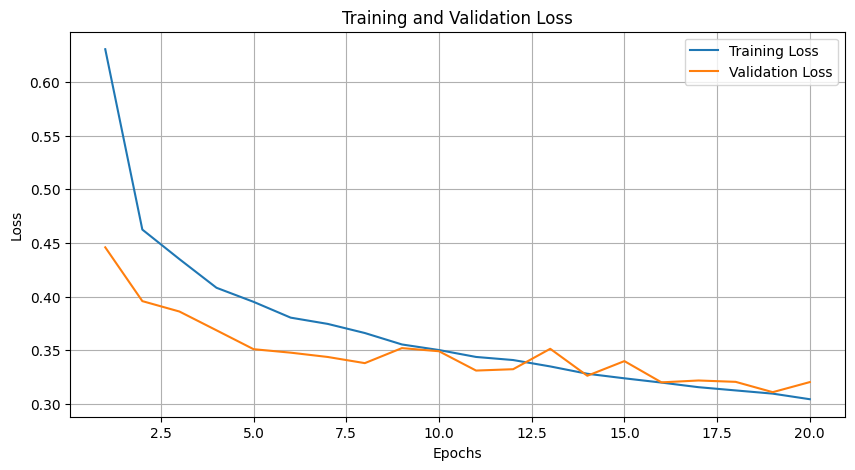

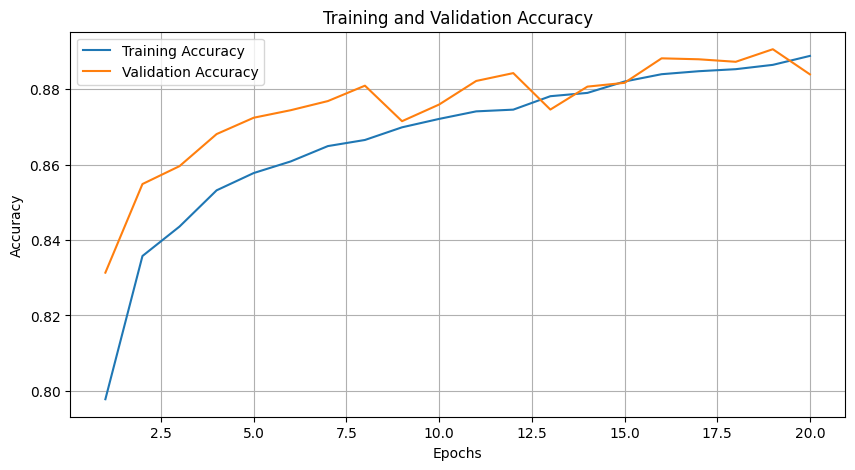

Validation Confusion Matrix:
 [[ 997    1   32   41    5    3  133    0    8    1]
 [   5 1185    4   23    5    0    1    0    1    0]
 [   8    0 1015   16  147    1   52    0    5    0]
 [  19    3    7 1144   56    1   22    0    3    0]
 [   2    3   71   37 1023    0   62    0    4    0]
 [   1    0    0    0    0 1092    0   48    3   24]
 [ 128    0  115   24  111    0  741    0   14    0]
 [   0    0    0    0    0   15    0 1135    1   44]
 [   1    0    3    6    5    6   11    6 1148    3]
 [   0    1    0    0    0    7    0   34    0 1127]]
Validation Macro F1 Score: 0.8829508232089379


In [35]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model4 = TestNeuralNetwork1(input_dim, output_dim, lr=0.001)
hyperTune(model4, train_dataset, output_dim)

Epoch 1/20, Training Loss: 0.5790073284900173 , Training Accuracy: 0.7925416666666667
Epoch 1/20, Validation Loss: 0.40675380043699855 , Validation Accuracy: 0.8538333333333333 , Validation Macro F1: 0.8409650217000912
Epoch 2/20, Training Loss: 0.4687510297517913 , Training Accuracy: 0.8324583333333333
Epoch 2/20, Validation Loss: 0.39483030161727883 , Validation Accuracy: 0.853 , Validation Macro F1: 0.8403209156901208
Epoch 3/20, Training Loss: 0.426762198271346 , Training Accuracy: 0.8452708333333333
Epoch 3/20, Validation Loss: 0.3819734046943909 , Validation Accuracy: 0.8583333333333333 , Validation Macro F1: 0.8452507204098356
Epoch 4/20, Training Loss: 0.4113096327497721 , Training Accuracy: 0.8515625
Epoch 4/20, Validation Loss: 0.3515258145635154 , Validation Accuracy: 0.8724166666666666 , Validation Macro F1: 0.8604016014522262
Epoch 5/20, Training Loss: 0.3951314824384156 , Training Accuracy: 0.8566666666666667
Epoch 5/20, Validation Loss: 0.35355480846128134 , Validation A

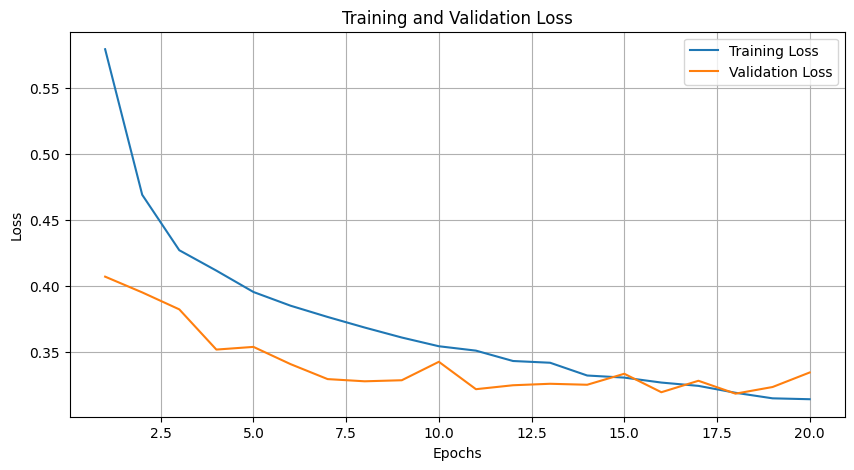

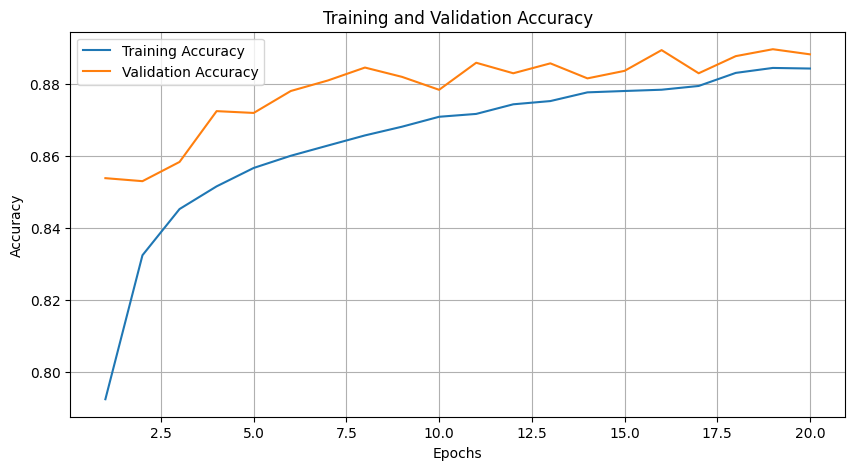

Validation Confusion Matrix:
 [[1001    0   18   33    1    6  135    0   19    0]
 [   3 1213    2   20    5    1    0    1    0    0]
 [  17    1  921   13  143    5   96    1    9    0]
 [  20    3   11  981   37    4   20    1   16    0]
 [   2    0   48   32 1057    3   63    0    5    1]
 [   0    0    0    0    0 1201    0   31    1   12]
 [ 127    0   69   31   84    5  841    1   17    0]
 [   0    0    0    0    0   17    0 1105    1   65]
 [   2    1    3    5    6    8   11    8 1154    1]
 [   0    0    0    0    0   11    0   30    0 1184]]
Validation Macro F1 Score: 0.8868711970458547


In [38]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model5 = TestNeuralNetwork1(input_dim, output_dim, lr=0.005)
hyperTune(model5, train_dataset, output_dim)

In [43]:
def evaluate(model, data_loader):
    all_preds = []
    all_labels = []
    for images, labels in data_loader:
        images = images.view(images.size(0), -1).numpy()
        probs = model.forward(images, training=False)
        preds = np.argmax(probs, axis=1)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
    return all_labels, all_preds

In [45]:

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_labels, test_preds = evaluate(model5, test_loader)
test_conf_matrix = confusion_matrix(test_labels, test_preds)
test_macro_f1 = f1_score(test_labels, test_preds, average='macro')
test_accuracy = accuracy_score(test_labels, test_preds)

print("Test Confusion Matrix:\n", test_conf_matrix)
# print("Test F1 Score:", test_f1)
print("Test Accuracy:", test_accuracy)
print("Test Macro F1 Score:", test_macro_f1)

Test Confusion Matrix:
 [[724   3  74  44  30   0 101   0  24   0]
 [  1 945   8  25  17   0   1   0   3   0]
 [  6   0 715   2 259   0  17   0   1   0]
 [ 10   6  64 788 115   0  11   0   6   0]
 [  0   0  46   3 942   0   7   0   2   0]
 [  0   0   0   0   0 806   0  62  16 116]
 [ 78   0 163  23 323   0 384   0  29   0]
 [  0   0   0   0   0   1   0 862   1 136]
 [  1   0   3   2  11   1   1   4 976   1]
 [  0   0   0   0   0   0   1  10   0 989]]
Test Accuracy: 0.8131
Test Macro F1 Score: 0.8102594034053245


Epoch 1/20, Training Loss: 0.6962044140139471 , Training Accuracy: 0.7503958333333334
Epoch 1/20, Validation Loss: 0.592677678331248 , Validation Accuracy: 0.79525 , Validation Macro F1: 0.7811915761171957
Epoch 2/20, Training Loss: 0.6259758493641429 , Training Accuracy: 0.7787916666666667
Epoch 2/20, Validation Loss: 0.4785627778396933 , Validation Accuracy: 0.8411666666666666 , Validation Macro F1: 0.8296852803338436
Epoch 3/20, Training Loss: 0.6040382333619091 , Training Accuracy: 0.7835208333333333
Epoch 3/20, Validation Loss: 0.4436509350169301 , Validation Accuracy: 0.83775 , Validation Macro F1: 0.825585425120278
Epoch 4/20, Training Loss: 0.5866391132297687 , Training Accuracy: 0.787875
Epoch 4/20, Validation Loss: 0.4092952111292012 , Validation Accuracy: 0.85225 , Validation Macro F1: 0.8392558393277758
Epoch 5/20, Training Loss: 0.5748667201870065 , Training Accuracy: 0.79475
Epoch 5/20, Validation Loss: 0.4425680486850154 , Validation Accuracy: 0.8466666666666667 , Valida

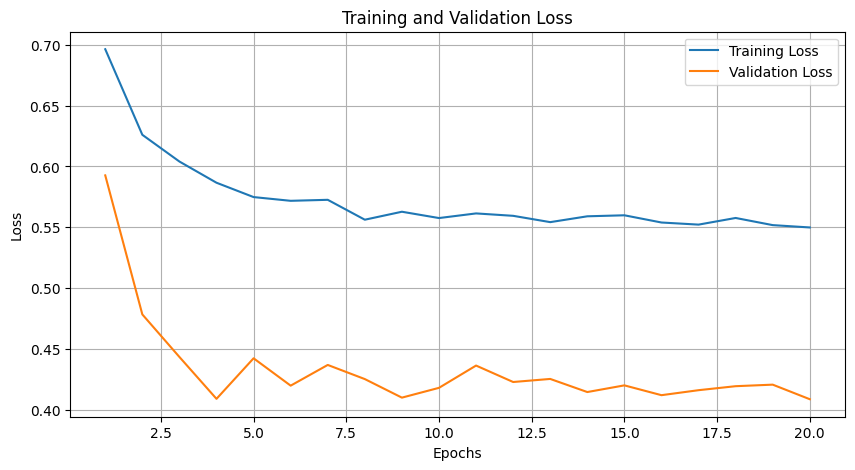

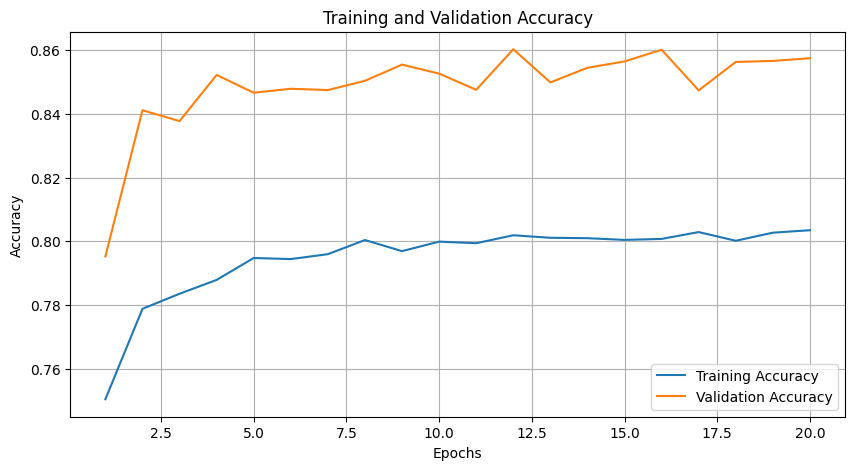

Validation Confusion Matrix:
 [[1056    5   28   48    8    2   61    0    4    0]
 [   2 1208    6   20    1    0    4    0    0    0]
 [  21    0  908   13  212    0   35    0    1    0]
 [  44   21    7 1039   60    0   16    0    4    0]
 [   2    2   75   21 1036    1   74    0    1    0]
 [   1    0    0    0    0 1025    0  108    5   30]
 [ 260    6  177   36  117    0  604    0    8    0]
 [   0    0    0    0    0    6    0 1178    1   27]
 [   5    1   13    6    7    1   16    5 1113    0]
 [   0    1    0    1    0    4    0   69    0 1123]]
Validation Macro F1 Score: 0.8548672737184946


In [46]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model6 = TestNeuralNetwork1(input_dim, output_dim, lr=0.05)
hyperTune(model6, train_dataset, output_dim)

Epoch 1/20, Training Loss: 0.7542113108374956 , Training Accuracy: 0.7713958333333333
Epoch 1/20, Validation Loss: 0.47500740239575906 , Validation Accuracy: 0.8360833333333333 , Validation Macro F1: 0.8241661317252226
Epoch 2/20, Training Loss: 0.5372210678742623 , Training Accuracy: 0.8111666666666667
Epoch 2/20, Validation Loss: 0.42882341260603213 , Validation Accuracy: 0.8474166666666667 , Validation Macro F1: 0.8356601381874378
Epoch 3/20, Training Loss: 0.4966608894585189 , Training Accuracy: 0.824875
Epoch 3/20, Validation Loss: 0.3986175716415144 , Validation Accuracy: 0.8575 , Validation Macro F1: 0.844074864212441
Epoch 4/20, Training Loss: 0.46942780285751845 , Training Accuracy: 0.835625
Epoch 4/20, Validation Loss: 0.38960923890603694 , Validation Accuracy: 0.861 , Validation Macro F1: 0.8474353674296233
Epoch 5/20, Training Loss: 0.4568632539725632 , Training Accuracy: 0.8378125
Epoch 5/20, Validation Loss: 0.382225246172948 , Validation Accuracy: 0.8635 , Validation Mac

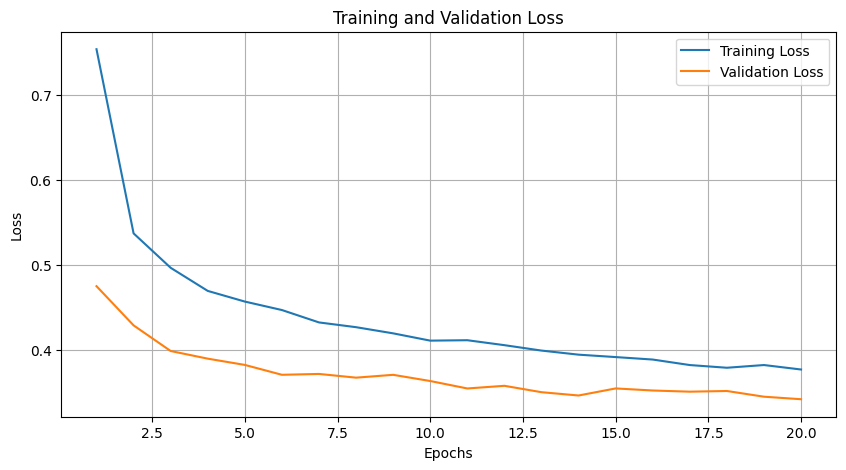

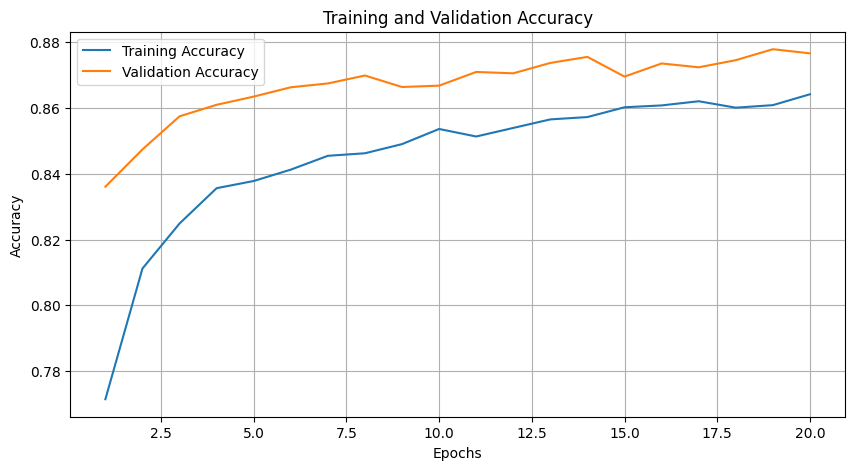

Validation Confusion Matrix:
 [[1031    1   13   36    1    0   79    0   13    0]
 [   6 1161    4   26    1    1    3    0    1    0]
 [  28    2  973   14  119    0   71    0    8    0]
 [  40   11    3 1099   25    0   25    0    4    1]
 [   5    1   82   35  986    0   70    0    5    0]
 [   0    0    0    0    0 1172    1   41   14   23]
 [ 241    2  121   39   89    0  732    1   19    0]
 [   0    0    0    0    0   20    0 1111    3   36]
 [   5    1    7    3    6    2    7    2 1154    1]
 [   0    0    0    0    0   11    0   50    1 1101]]
Validation Macro F1 Score: 0.8756317013126174


In [47]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model7 = TestNeuralNetwork2(input_dim, output_dim, lr=0.001)
hyperTune(model7, train_dataset, output_dim)

Epoch 1/20, Training Loss: 0.6409080589587385 , Training Accuracy: 0.77575
Epoch 1/20, Validation Loss: 0.46222000109462164 , Validation Accuracy: 0.8263333333333334 , Validation Macro F1: 0.8066532501622942
Epoch 2/20, Training Loss: 0.5008229982371941 , Training Accuracy: 0.8215625
Epoch 2/20, Validation Loss: 0.4241094452300413 , Validation Accuracy: 0.8383333333333334 , Validation Macro F1: 0.8230015522766031
Epoch 3/20, Training Loss: 0.4706107331700982 , Training Accuracy: 0.8315208333333334
Epoch 3/20, Validation Loss: 0.40148528728201616 , Validation Accuracy: 0.8498333333333333 , Validation Macro F1: 0.8371127912177522
Epoch 4/20, Training Loss: 0.4569429064393226 , Training Accuracy: 0.8369166666666666
Epoch 4/20, Validation Loss: 0.39415799773592036 , Validation Accuracy: 0.849 , Validation Macro F1: 0.8377200023658707
Epoch 5/20, Training Loss: 0.44373104082516934 , Training Accuracy: 0.8414583333333333
Epoch 5/20, Validation Loss: 0.3905643617554518 , Validation Accuracy: 

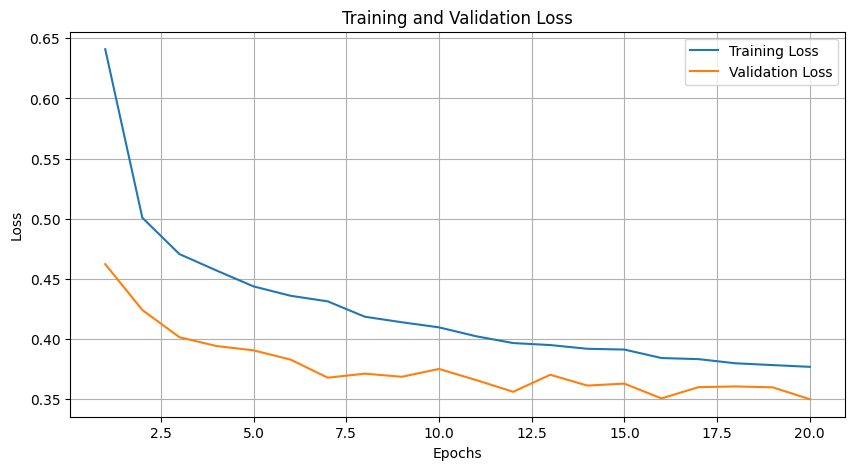

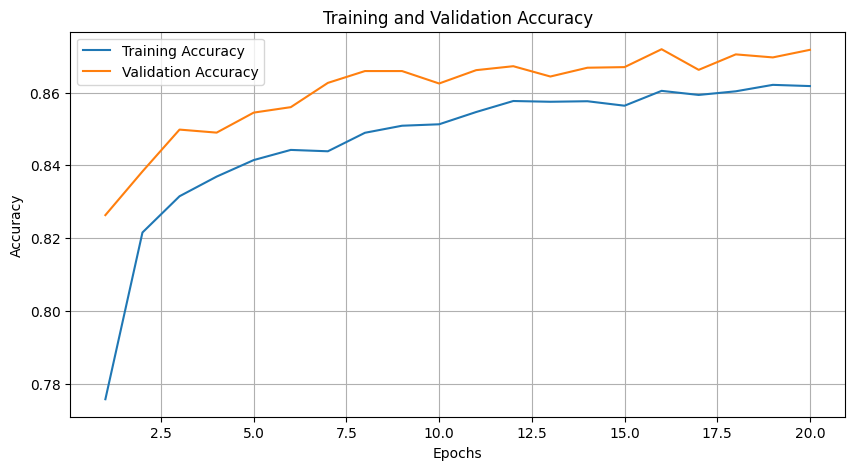

Validation Confusion Matrix:
 [[ 987    0   14   34    7    6  137    0    8    0]
 [   9 1156    2   15    2    0    5    0    0    0]
 [  26    0  925   11  144    3   53    0    8    0]
 [  37    2   15 1048   43    2   25    0    4    0]
 [   3    0   92   25  996    2   73    0    3    0]
 [   1    0    0    0    0 1133    0   37    3    8]
 [ 189    2  130   29  119    4  797    1   11    0]
 [   0    0    0    0    0   39    0 1112    0   46]
 [   6    1    7    2    9    8   14    5 1195    1]
 [   0    0    0    0    0   19    0   38    0 1112]]
Validation Macro F1 Score: 0.8722193479449073


In [48]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model8 = TestNeuralNetwork2(input_dim, output_dim, lr=0.005)
hyperTune(model8, train_dataset, output_dim)

Epoch 1/20, Training Loss: 0.7201440008626181 , Training Accuracy: 0.7374583333333333
Epoch 1/20, Validation Loss: 0.5136967950398925 , Validation Accuracy: 0.8124166666666667 , Validation Macro F1: 0.796719131396362
Epoch 2/20, Training Loss: 0.6236221492274515 , Training Accuracy: 0.7762708333333334
Epoch 2/20, Validation Loss: 0.4620161089836316 , Validation Accuracy: 0.8371666666666666 , Validation Macro F1: 0.8233732879000228
Epoch 3/20, Training Loss: 0.5971165468325089 , Training Accuracy: 0.785
Epoch 3/20, Validation Loss: 0.4611031491235417 , Validation Accuracy: 0.8370833333333333 , Validation Macro F1: 0.8246434956914834
Epoch 4/20, Training Loss: 0.5889739620844733 , Training Accuracy: 0.7875833333333333
Epoch 4/20, Validation Loss: 0.4786104073213385 , Validation Accuracy: 0.8231666666666667 , Validation Macro F1: 0.8063063849414258
Epoch 5/20, Training Loss: 0.5843522716927253 , Training Accuracy: 0.7909166666666667
Epoch 5/20, Validation Loss: 0.4240506180086975 , Valida

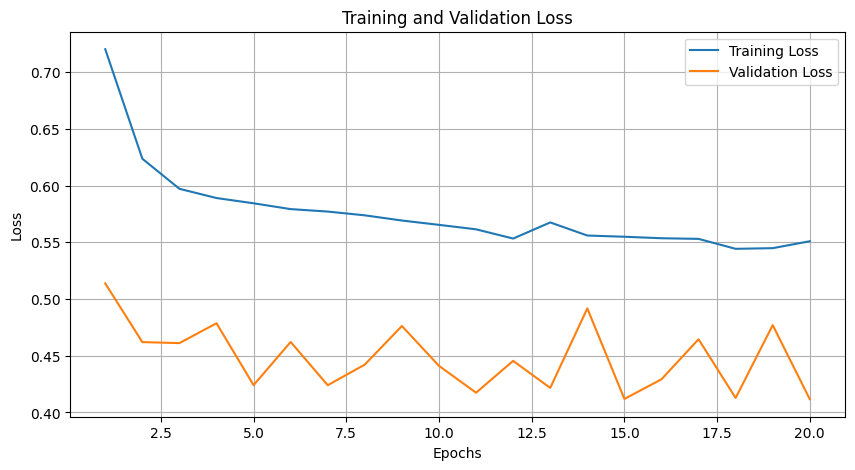

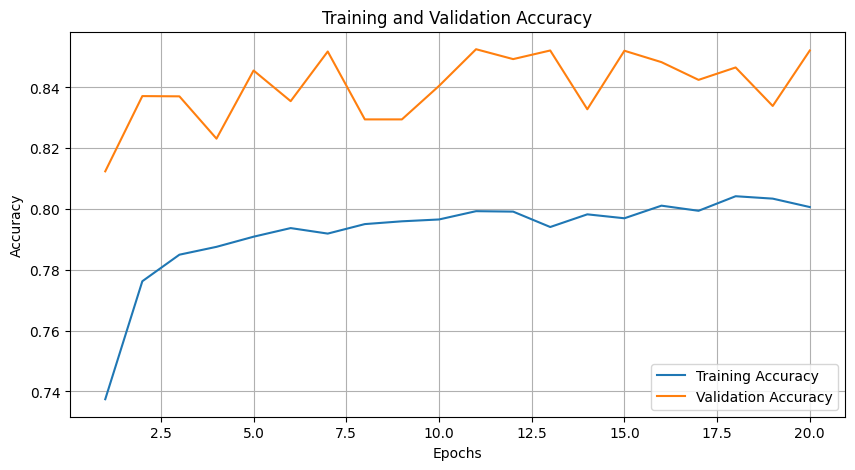

Validation Confusion Matrix:
 [[ 943    1   15   48    6    0  152    0    6    0]
 [   5 1121    0   24    4    0    7    0    0    0]
 [  11    2  802    7  232    0  170    1    2    0]
 [  36   17    8 1032   69    0   35    0    0    0]
 [   2    2   45   22  992    0   97    0    3    0]
 [   0    0    0    1    0 1176    0   39    5   45]
 [ 183    3   89   25  109    0  831    0    7    0]
 [   0    0    0    0    0   37    0 1089    3   86]
 [   1    0    6   10   10    6   41    2 1094    3]
 [   0    0    0    2    0   10    1   21    0 1146]]
Validation Macro F1 Score: 0.853726360946436


In [49]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model9 = TestNeuralNetwork2(input_dim, output_dim, lr=0.05)
hyperTune(model9, train_dataset, output_dim)

Epoch 1/20, Training Loss: 0.8068051349309161 , Training Accuracy: 0.7455416666666667
Epoch 1/20, Validation Loss: 0.43733767889129843 , Validation Accuracy: 0.8466666666666667 , Validation Macro F1: 0.8295229676546494
Epoch 2/20, Training Loss: 0.5579543120829448 , Training Accuracy: 0.8082708333333334
Epoch 2/20, Validation Loss: 0.3939565492010846 , Validation Accuracy: 0.855 , Validation Macro F1: 0.8386323733604135
Epoch 3/20, Training Loss: 0.5184051721378458 , Training Accuracy: 0.82175
Epoch 3/20, Validation Loss: 0.44187035558284143 , Validation Accuracy: 0.8474166666666667 , Validation Macro F1: 0.8274604323378212
Epoch 4/20, Training Loss: 0.49369981755777204 , Training Accuracy: 0.8293958333333333
Epoch 4/20, Validation Loss: 0.37512945531064373 , Validation Accuracy: 0.86125 , Validation Macro F1: 0.8471915213236939
Epoch 5/20, Training Loss: 0.47864195686723876 , Training Accuracy: 0.8348541666666667
Epoch 5/20, Validation Loss: 0.40055932842918013 , Validation Accuracy: 

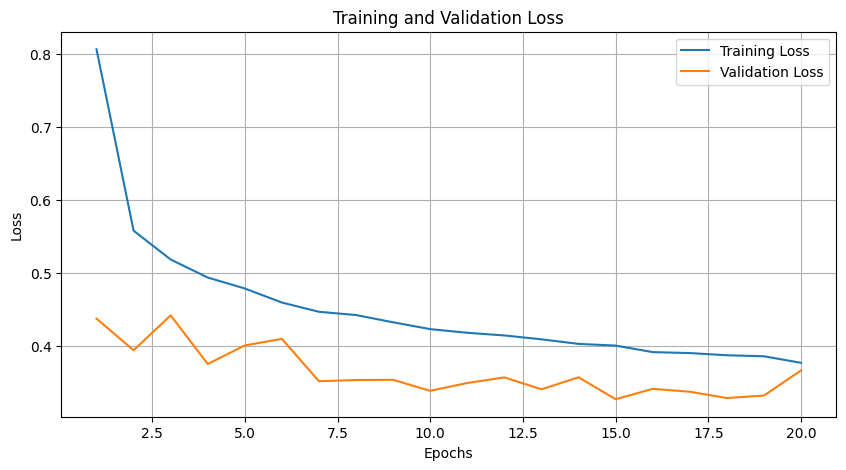

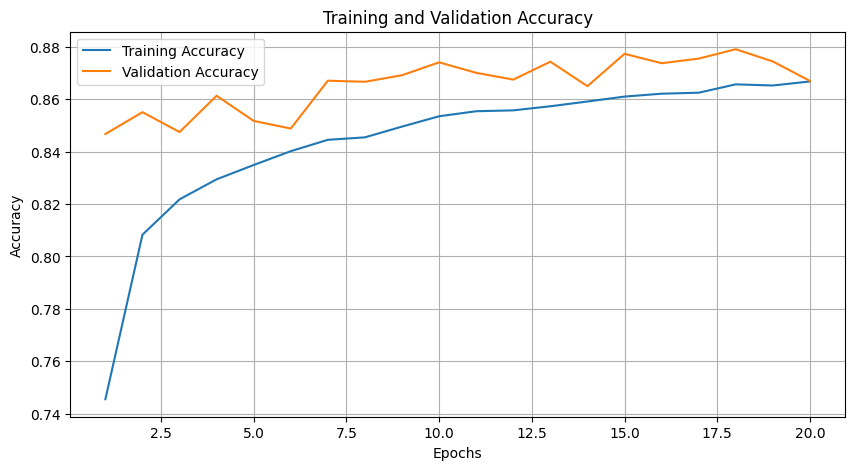

Validation Confusion Matrix:
 [[ 961    1   15   37    6    1  206    0   21    0]
 [   5 1136    5   30   13    0    0    0    2    0]
 [   9    0  773    6  198    0  158    0    9    0]
 [  30    0    7 1041   66    1   46    0   21    1]
 [   0    0   40   30 1057    0  117    0   10    0]
 [   1    0    0    0    0 1238    0   24    5   12]
 [ 118    0   51   25   80    0  831    0   26    0]
 [   0    0    0    0    0   40    0 1136    5   25]
 [   0    0    2    1    5    1    8    0 1182    0]
 [   0    0    0    0    0   25    0   47    5 1048]]
Validation Macro F1 Score: 0.8668565136866235


In [50]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model10 = TestNeuralNetwork3(input_dim, output_dim, lr=0.001)
hyperTune(model10, train_dataset, output_dim)

Epoch 1/20, Training Loss: 0.6987305935442574 , Training Accuracy: 0.7553958333333334
Epoch 1/20, Validation Loss: 0.4487056608664686 , Validation Accuracy: 0.8380833333333333 , Validation Macro F1: 0.8274620094905265
Epoch 2/20, Training Loss: 0.5515315480744217 , Training Accuracy: 0.8102916666666666
Epoch 2/20, Validation Loss: 0.398400028896597 , Validation Accuracy: 0.8511666666666666 , Validation Macro F1: 0.8403390453884189
Epoch 3/20, Training Loss: 0.5145344026379602 , Training Accuracy: 0.8215208333333334
Epoch 3/20, Validation Loss: 0.3911809087567883 , Validation Accuracy: 0.86125 , Validation Macro F1: 0.8486148010354464
Epoch 4/20, Training Loss: 0.4895507692379957 , Training Accuracy: 0.8288541666666667
Epoch 4/20, Validation Loss: 0.3942908846065435 , Validation Accuracy: 0.8555833333333334 , Validation Macro F1: 0.8466339798403549
Epoch 5/20, Training Loss: 0.4734477797945944 , Training Accuracy: 0.8339583333333334
Epoch 5/20, Validation Loss: 0.39678883147676886 , Val

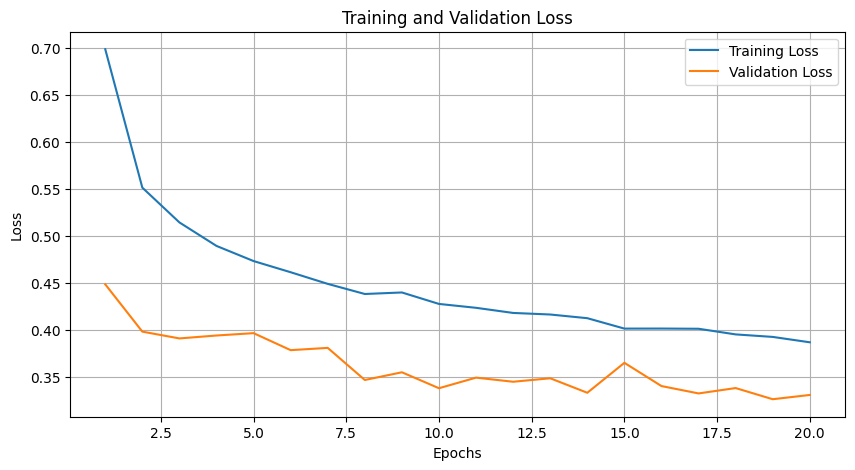

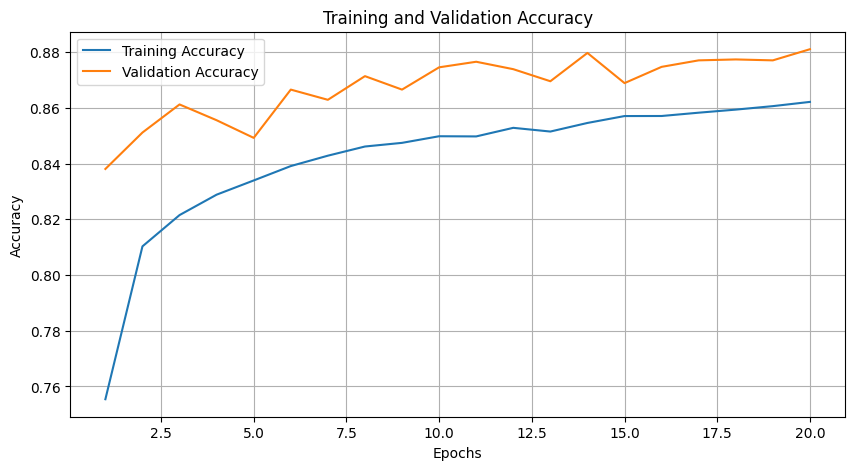

Validation Confusion Matrix:
 [[1040    8   12   87    6    0   44    0   13    0]
 [   4 1128    4   24    0    1    0    0    1    0]
 [  18    1  962   20  116    3   67    0    4    0]
 [  18    7    5 1138   30    0   12    0    4    0]
 [   1    0   70   84 1038    0   49    0    7    0]
 [   0    0    0    1    0 1149    0   43    3    7]
 [ 219    2  127   71   92    1  703    0   14    0]
 [   0    0    0    0    0   18    0 1175    2   24]
 [   2    1    1    4    7    7    6    4 1106    2]
 [   0    0    0    0    0   13    0   36    0 1134]]
Validation Macro F1 Score: 0.8799250137914072


In [64]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model11 = TestNeuralNetwork3(input_dim, output_dim, lr=0.005)
hyperTune(model11, train_dataset, output_dim)

Epoch 1/20, Training Loss: 0.8136329416266735 , Training Accuracy: 0.7078125
Epoch 1/20, Validation Loss: 0.5156105100911507 , Validation Accuracy: 0.8126666666666666 , Validation Macro F1: 0.7992885929597937
Epoch 2/20, Training Loss: 0.6887646441179833 , Training Accuracy: 0.7605
Epoch 2/20, Validation Loss: 0.47713178485179025 , Validation Accuracy: 0.8264166666666667 , Validation Macro F1: 0.8102030785770444
Epoch 3/20, Training Loss: 0.6572573613811542 , Training Accuracy: 0.7725416666666667
Epoch 3/20, Validation Loss: 0.5043463207220897 , Validation Accuracy: 0.8216666666666667 , Validation Macro F1: 0.8034186811705274
Epoch 4/20, Training Loss: 0.6327414601990392 , Training Accuracy: 0.7820416666666666
Epoch 4/20, Validation Loss: 0.43535674131558955 , Validation Accuracy: 0.8394166666666667 , Validation Macro F1: 0.8265283423461391
Epoch 5/20, Training Loss: 0.624656478555032 , Training Accuracy: 0.785
Epoch 5/20, Validation Loss: 0.4369116853578168 , Validation Accuracy: 0.84

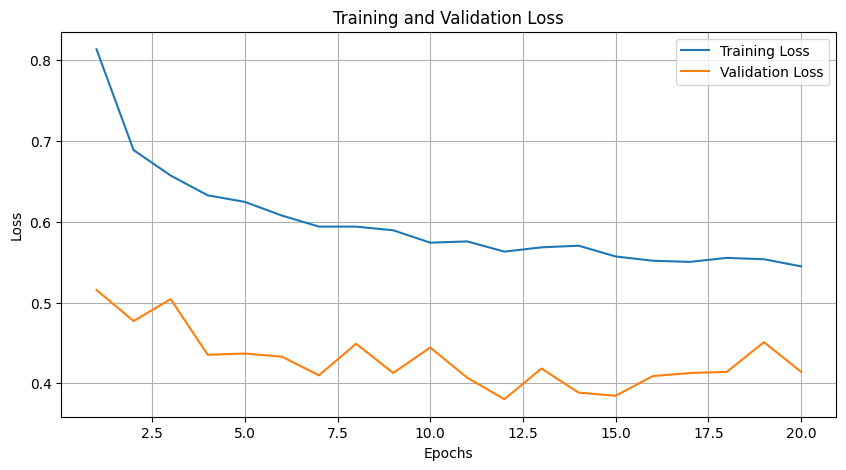

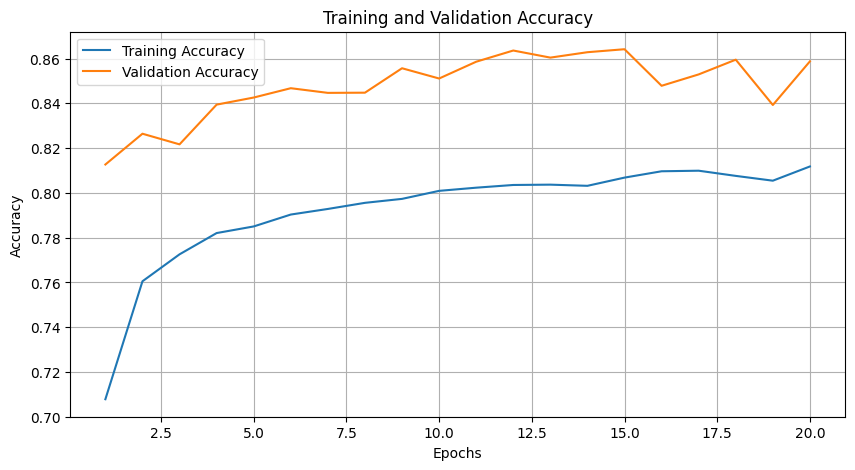

Validation Confusion Matrix:
 [[1008    0   10  105    2    0   64    0   10    0]
 [   4 1072    2   94    3    0    0    0    0    0]
 [  20    0  980   27  188    0   60    0    0    0]
 [  14    0    6 1145   14    0   12    0    0    0]
 [   1    1   64  120  927    0   70    0    1    0]
 [   0    0    0    0    0 1098    0   48    2    8]
 [ 205    1  101  106  110    0  712    1    6    0]
 [   0    0    0    0    0   24    0 1104    0   50]
 [   7    0    6   24   11    4   17    9 1134    0]
 [   0    0    0    1    1   26    0   35    0 1125]]
Validation Macro F1 Score: 0.8592589538216586


In [52]:
input_dim = 28 * 28  # Image size is 28x28
output_dim = 10  # Number of classes in FashionMNIST
model12 = TestNeuralNetwork3(input_dim, output_dim, lr=0.05)
hyperTune(model12, train_dataset, output_dim)

#Save_And_Load

In [53]:
import pickle

def save_weights(model, filename):
    params_weights_dict = {
        "input_dim": model.input_dim,
        "output_dim": model.output_dim,
        "hidden_dim": model.hidden_dim,
        "dropout_rate": model.dropout_rate,
        "lr": model.lr,
        "dense1_weights": model.dense1.weights,
        "dense1_biases": model.dense1.biases,
        "dense2_weights": model.dense2.weights,
        "dense2_biases": model.dense2.biases,
        "batch_norm1_gamma": model.batch_norm1.gamma,
        "batch_norm1_beta": model.batch_norm1.beta
    }
    with open(filename, 'wb') as f:
        pickle.dump(params_weights_dict, f)
    print(f"Weights saved to {filename}")
    
def load_weights(model, filename):
    with open(filename, 'rb') as f:
        weights_dict = pickle.load(f)
    model.input_dim = weights_dict["input_dim"]
    model.output_dim = weights_dict["output_dim"]
    model.hidden_dim = weights_dict["hidden_dim"]
    model.dropout_rate = weights_dict["dropout_rate"]
    model.lr = weights_dict["lr"]
    model.dense1.weights = weights_dict["dense1_weights"]
    model.dense1.biases = weights_dict["dense1_biases"]
    model.dense2.weights = weights_dict["dense2_weights"]
    model.dense2.biases = weights_dict["dense2_biases"]
    model.batch_norm1.gamma = weights_dict["batch_norm1_gamma"]
    model.batch_norm1.beta = weights_dict["batch_norm1_beta"]
    
    print(f"Weights loaded from {filename}")

In [59]:
def save_weights_big(model, filename):
    params_weights_dict = {
        "input_dim": model.input_dim,
        "output_dim": model.output_dim,
        "hidden_dim": model.hidden_dim,
        "dropout_rate": model.dropout_rate,
        "lr": model.lr,
        "dense1_weights": model.dense1.weights,
        "dense1_biases": model.dense1.biases,
        "dense2_weights": model.dense2.weights,
        "dense2_biases": model.dense2.biases,
        "dense3_weights": model.dense3.weights,
        "dense3_biases": model.dense3.biases,
        "batch_norm1_gamma": model.batch_norm1.gamma,
        "batch_norm1_beta": model.batch_norm1.beta,
        "batch_norm2_gamma": model.batch_norm2.gamma,
        "batch_norm2_beta": model.batch_norm2.beta
    }
    with open(filename, 'wb') as f:
        pickle.dump(params_weights_dict, f)
    print(f"Weights saved to {filename}")
    
def load_weights_big(model, filename):
    with open(filename, 'rb') as f:
        weights_dict = pickle.load(f)
    model.input_dim = weights_dict["input_dim"]
    model.output_dim = weights_dict["output_dim"]
    model.hidden_dim = weights_dict["hidden_dim"]
    model.dropout_rate = weights_dict["dropout_rate"]
    model.lr = weights_dict["lr"]
    model.dense1.weights = weights_dict["dense1_weights"]
    model.dense1.biases = weights_dict["dense1_biases"]
    model.dense2.weights = weights_dict["dense2_weights"]
    model.dense2.biases = weights_dict["dense2_biases"]
    model.dense3.weights = weights_dict["dense3_weights"]
    model.dense3.biases = weights_dict["dense3_biases"]
    model.batch_norm1.gamma = weights_dict["batch_norm1_gamma"]
    model.batch_norm1.beta = weights_dict["batch_norm1_beta"]
    model.batch_norm2.gamma = weights_dict["batch_norm2_gamma"]
    model.batch_norm2.beta = weights_dict["batch_norm2_beta"]
    
    
    print(f"Weights loaded from {filename}")

In [ ]:
save_weights(model5, 'model_weights.pkl')

# Load the model weights later


In [ ]:

new_model = TestNeuralNetwork1(input_dim=784, output_dim=10)
load_weights(new_model, "model_weights.pkl")

In [68]:
save_weights_big(model11, 'model_weights_big.pkl')

Weights saved to model_weights_big.pkl


In [69]:
new_model_big = TestNeuralNetwork3(input_dim=784, output_dim=10)
load_weights_big(new_model_big, "model_weights_big.pkl")

Weights loaded from model_weights_big.pkl


In [70]:
def evaluate(model, data_loader):
    all_preds = []
    all_labels = []
    for images, labels in data_loader:
        images = images.view(images.size(0), -1).numpy()
        probs = model.forward(images, training=False)
        preds = np.argmax(probs, axis=1)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
    return all_labels, all_preds

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_labels, test_preds = evaluate(new_model_big, test_loader)
test_conf_matrix = confusion_matrix(test_labels, test_preds)
test_macro_f1 = f1_score(test_labels, test_preds, average='macro')
test_accuracy = accuracy_score(test_labels, test_preds)

print("Test Confusion Matrix:\n", test_conf_matrix)
# print("Test F1 Score:", test_f1)
print("Test Accuracy:", test_accuracy)
print("Test Macro F1 Score:", test_macro_f1)

Test Confusion Matrix:
 [[869  37  11   3  14   0  37   0  27   2]
 [  1 979   0  10   6   0   1   0   2   1]
 [ 20   5 687   2 237   0  29   0  15   5]
 [ 71 109  12 655 109   0  20   0  14  10]
 [  0   1  56   4 916   0  17   0   5   1]
 [  0   0   0   0   0 711   0  53   8 228]
 [217  14  96   4 233   0 384   0  48   4]
 [  0   0   0   0   0   1   0 711   1 287]
 [  1   3   1   0   6   1   1   2 980   5]
 [  0   0   0   0   0   0   1   2   0 997]]
Test Accuracy: 0.7889
Test Macro F1 Score: 0.7822296571192444
